# Price Prediction

To help make purchasing or selling decisions on a certain sneaker it might be usefull to consider ***how the price will change***. This notebook aims to achieve just that.

In the previous notebook 'sneaker_scraping' a price history was obtained for the 'Name' you introduced. Now with that information, we intend to make an acurate prediction for the price of this shoe name. We use Time Series Analysis to build a model that makes predictions taking into account:
- past values of this price time series and 
- a covariate obtained from Google Trends that represents the attention this shoe model gets. 

The predictions are made 3 days ahead. So for any given day $t$, we can get a value of price of day $t+1$, $t+2$ and $t+3$ (more on this later).

This notebook has three parts. In the first part, the 'attention' covariate and the 'price' variable are loaded/created and visualized. Afterwards, the model is defined, tuned and estimated in the second part. Lastly, predictions are made in the third and last part.

## Price and Attention 

In [1]:
from pytrends.request import TrendReq
import time
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib  import dates
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Price History

Here the chosen value for **name** should be the same as the one introduced in the sneaker_scraping notebook, to have comparable information for the prediction.

In [2]:
name = 'Jordan 1 Mid'

In [3]:
# Read the price history scrapped in 'sneaker_scraping'
path = 'https://www.dropbox.com/s/pqzy3svtsdjtjim/price_history_df.csv?dl=1'
df = pd.read_csv(path, index_col=None, header=0)

In [4]:
df.columns = [0, name]
df = df.set_index(0)
df.index = pd.to_datetime(df.index)
df

,Jordan 1 Mid
0,
2021-03-13 22:24:07,119
2021-03-14 19:45:43,119
2021-03-15 17:07:19,119
2021-03-16 14:28:55,119
2021-03-17 11:50:31,122
...,...
2021-06-06 11:36:07,138
2021-06-07 08:57:43,140
2021-06-08 06:19:19,141


In [5]:
# group by day
y_day = pd.DataFrame(df.groupby([df.index.strftime('%Y-%m-%d')])[name].mean())
y_day.columns = [name]
y_day

,Jordan 1 Mid
0,
2021-03-13,119.0
2021-03-14,119.0
2021-03-15,119.0
2021-03-16,119.0
2021-03-17,122.0
...,...
2021-06-06,138.0
2021-06-07,140.0
2021-06-08,141.0


In [6]:
# drop zeros if the series has less than 90 prices
y_day = y_day[(y_day.T != 0).any()]
y_day

,Jordan 1 Mid
0,
2021-03-13,119.0
2021-03-14,119.0
2021-03-15,119.0
2021-03-16,119.0
2021-03-17,122.0
...,...
2021-06-06,138.0
2021-06-07,140.0
2021-06-08,141.0


### Google Trends Data

###### A note on lags
Since this will be our covariate, together with past values of the price, we need to lag it with respect to the price. Also, since we want to make predictions 3 days ahead into the future, **we need a lag of 3 between the response variable and the covariate**. 

This way, if on day 10 we want to make predictions for day 11, 12 and 13, we can operate with values of price and "attention". For example, to make a prediction on day 10 **for day 11** we use historical data of price (up to day 10) and data from google trends of only day 8: 

$predprice_{t=11} = f(trueprice_{t\le10}, google_{t=8})$

Likewise, to make a prediction on day 10 **for day 13** we need: historical data (up to day 10) and data from google trends of day 10. We would also have available the predictions we made before, and thefore we would use them:

$predprice_{t=13} = f(trueprice_{t\le10}, predprice_{t=11,12}, google_{t=10})$

This function $f$ is our model and will be explained later.


###### Combining the data available
To get data from Google Trends up to today, two steps have to be followed:  
- get historical daily data (missing last 2-3 days) and
- get the last week of hourly data. 

This way it can be groupped and merged into one data set.

##### Step1. Historical daily data

In [7]:
kw_list = [name]

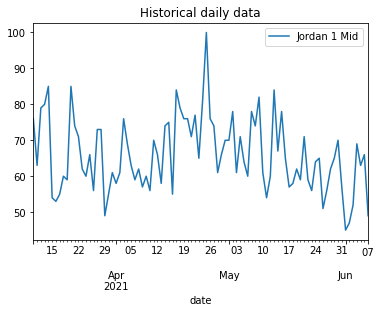

In [8]:
# take the first date from prices - lag=3
lag =3
time_start = datetime.strptime(y_day[name].index[0], '%Y-%m-%d') - timedelta(days=lag)
time_start =   time_start.strftime('%Y-%m-%d')
time_end =   datetime.today().strftime('%Y-%m-%d')
timeframe = time_start + " " + time_end

startTime = time.time()
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='', gprop='')

x = pytrends.interest_over_time()
del x['isPartial'] 

x.plot(title="Historical daily data");

##### Step 2. Past week hourly data

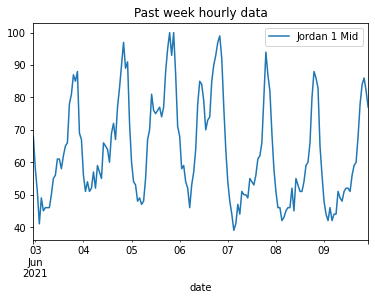

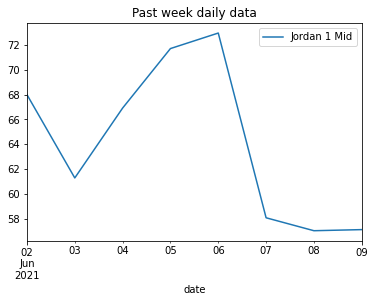

In [9]:
timeframe = 'now 7-d'
pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='', gprop='')
x_7 = pytrends.interest_over_time()
del x_7['isPartial'] 
x_7.plot(title="Past week hourly data");

x_7day = pd.DataFrame(x_7.groupby([x_7.index.strftime('%Y-%m-%d')])[name].mean())
x_7day.columns = [name]
x_7day.index = pd.to_datetime(x_7day.index)
x_7day.plot(title="Past week daily data");

It is important to note that google trends' way of measuring attention can be problematic for merging both data sets. This is because google scales the attention measurement differently for each of the step 1 and 2. Nevertheless, it was confirmed testing several sneaker names that it is better to proceed in this way. The other approach would be to use a larger lag between the $price$ and $attention$, and just get data following step 1.

In [10]:
# merge both sets

x_f = x.append(x_7day)
is_duplicate = x_f.index.duplicated(keep="first")
not_duplicate = ~is_duplicate
x_f = x_f[~is_duplicate]

Finally, the full <b style="color:red"> $\mathbf{price}$ </b> and <b style="color:blue"> $\mathbf{attention}$ </b> time series can be presented below:

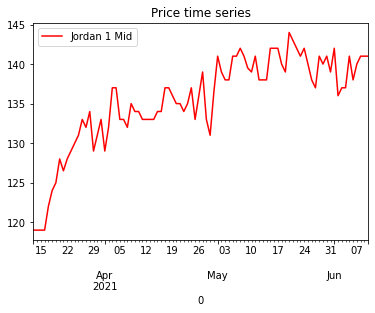

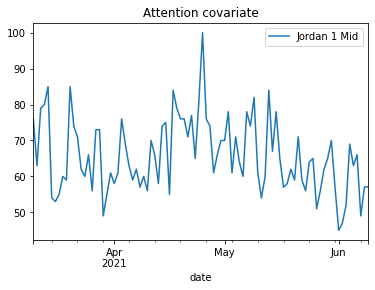

In [11]:
# price time series
y_day.index = pd.to_datetime(y_day.index)
y_day.plot(color="red", title="Price time series" );

# attention covariate
x_f.plot(title="Attention covariate");

###### Defining the training set and test set

As it was mentioned at the begging, predictions are made for three days in advance. So the test and train set of the price time series are chosen to be:

In [12]:
test = y_day[-3:]
train = y_day[:-3]

Once the price has been split, the attention covariate can also be split:

In [13]:
train_x = x_f[:len(train)]
test_x = x_f[len(train):len(train)+3]

## Model Definition and Estimation

There are many techniques to do time series analysis. In this problem, for convenience we use the **ARIMAX** model. 

We need a flexible procedure that is able to fit the best possible model under the ARIMAX framework. For any given 'Name' sneaker we need the model to:
- define the best amount and type of parameters,
- estimate them by training itself and
- give an idea of the error we could make when predicting.

All of this can be achieved using the **auto_arima** function from the pmdarima package. This function essentially compares multiple options of models by their Akaike Information Criterion (AIC) values, which are a measure of predictive power.

### auto_arima


This function needs to be given initial values of the parameters of an ARIMA model. Choosing these intial values was done for a single sneaker, through the use of Autocorrelation and Partical Autocorrelation plots.

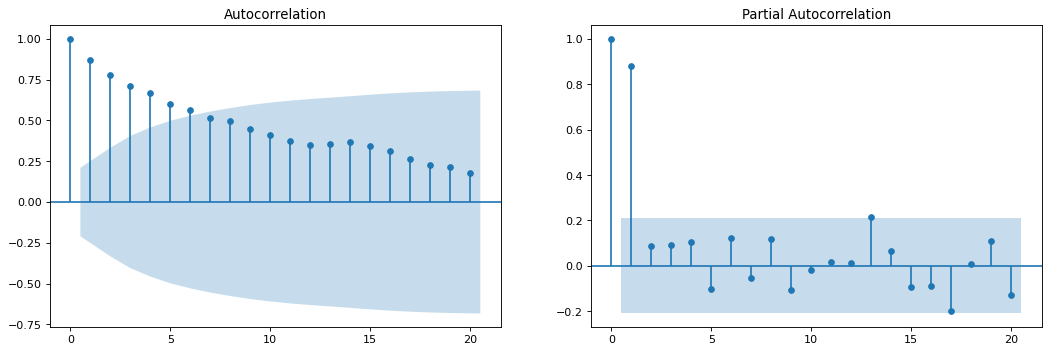

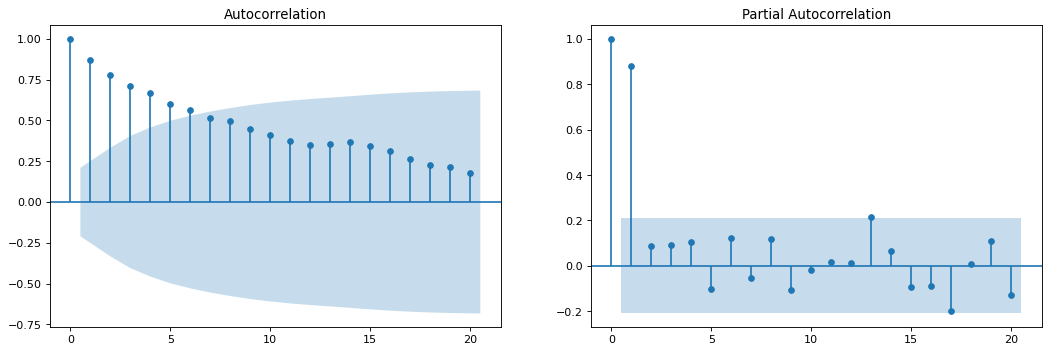

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5), dpi= 80)
plot_acf(train, ax=ax1, lags=20)
plot_pacf(train, ax=ax2, lags=20) #due to a bug on the package's function, this line might does not work for small time series

Once the intial values are chosen, two models are proposed:
- Model 1: includes just the price data
- Model 2: includes the attention covariate

For the sneaker names tested on this notebook, Model 1 gave normally better results. Both are included for comparison of the results of this section.

###### Model 1: including google trends data

In [15]:
# model with googel trends
arima_model = auto_arima(train, train_x, start_p=1, d=0, start_q=5, max_p=5, max_d=2, max_q=20, sart_P=0, D=0, start_Q=0, max_P=1, max_Q=3, max_D=0, m=7, seasonal=True, error_action='warn', trace=True, supress_warnings=True, random=False, stepwise=True)
pred = pd.DataFrame(arima_model.predict(n_periods=3, X=test_x), index=test.index)

Performing stepwise search to minimize aic
 ARIMA(1,0,5)(1,0,0)[7] intercept   : AIC=413.168, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=557.731, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=407.177, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=483.334, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=789.260, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=405.112, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=407.068, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=401.302, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=403.515, Time=0.25 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=403.302, Time=0.33 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=494.637, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=412.835, Time=0.2

###### Model 2: not including google trends data

In [16]:
# model without googel trends
arima_model2 = auto_arima(train, start_p=2, d=0, start_q=0, max_p=5, max_d=0, max_q=5, sart_P=0, D=0, start_Q=0, max_P=1, max_Q=3, max_D=0, m=7, seasonal=True, error_action='warn', trace=True, supress_warnings=True, random=False, stepwise=True)
pred2 = pd.DataFrame(arima_model2.predict(n_periods=3), index=test.index)

Performing stepwise search to minimize aic
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=405.048, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=557.394, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=405.071, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=481.484, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1102.804, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=402.480, Time=0.11 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=404.492, Time=0.18 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=406.115, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=403.144, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[7] intercept   : AIC=400.412, Time=0.14 sec
 ARIMA(3,0,0)(1,0,0)[7] intercept   : AIC=403.568, Time=0.24 sec
 ARIMA(3,0,0)(0,0,1)[7] intercept   : AIC=403.781, Time=0.20 sec
 ARIMA(3,0,0)(1,0,1)[7] intercept   : AIC=405.882, Time=0.29 sec
 ARIMA(4,0,0)(0,0,0)[7] intercept   : AIC=407.922, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[7] intercept   : AIC=406.

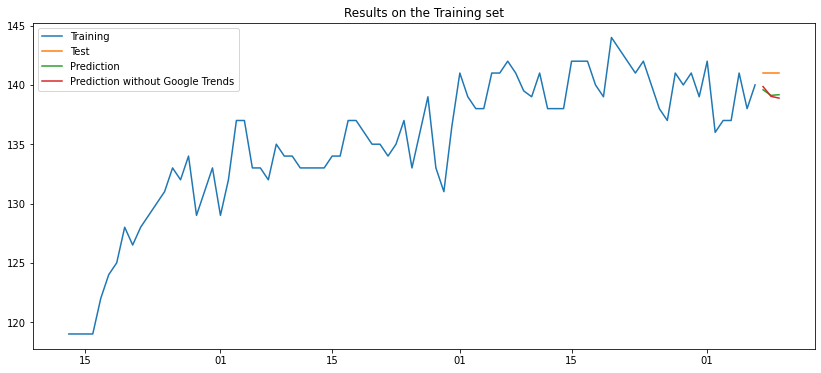

In [17]:
plt.rcParams["figure.figsize"] = (14,6)

plt.plot(train)
plt.plot(test)
plt.plot(pred)
plt.plot(pred2)
plt.legend(['Training','Test','Prediction','Prediction without Google Trends'])
plt.title('Results on the Training set')

formatter = dates.DateFormatter('%d')

ax = plt.gcf().axes[0] 
ax.xaxis.set_major_formatter(formatter)

## Making Predictions

Finally, a prediction can be computed from today 3 days into the future.

In [18]:
train = y_day
test = y_day[name].index[-3:] + timedelta(days=3)

train_x = x_f[:len(train)]
test_x = x_f[-3:]

In [19]:
arima_model = auto_arima(y_day, train_x, start_p=3, d=0, start_q=1, max_p=5, max_d=0, max_q=5, sart_P=0, D=0, start_Q=0, max_P=1, max_Q=3, max_D=0, m=7, seasonal=True, error_action='warn', trace=True, supress_warnings=True, random=True, stepwise=True)
pred = pd.DataFrame(arima_model.predict(n_periods=3, X=test_x), index=test)

Performing stepwise search to minimize aic
 ARIMA(3,0,1)(1,0,0)[7] intercept   : AIC=424.911, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=576.194, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=418.042, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=499.286, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=817.768, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=416.089, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=418.115, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=415.497, Time=0.16 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=417.592, Time=0.28 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=425.590, Time=0.29 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=416.958, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[7] intercept   : AIC=412.037, Time=0.23 sec
 ARIMA(3,0,0)(1,0,0)[7] intercept   : AIC=414.755, Time=0.41 sec
 ARIMA(3,0,0)(0,0,1)[7] intercept   : AIC=413.676, 

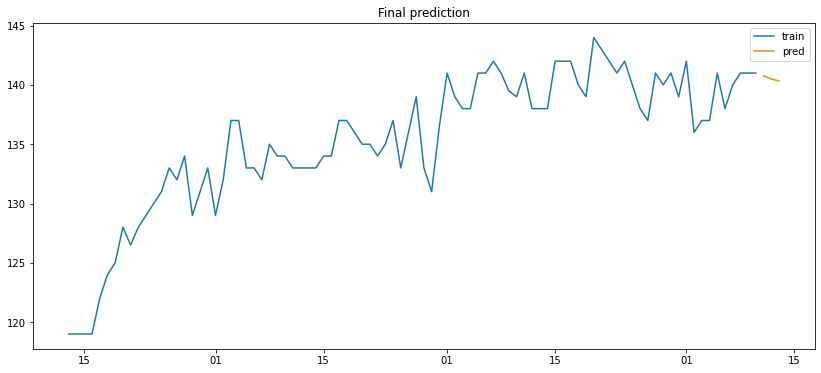

In [20]:
plt.rcParams["figure.figsize"] = (14,6)
plt.plot(y_day)
plt.plot(pred)

plt.title('Final prediction')
plt.legend(['train','pred'])
formatter = dates.DateFormatter('%d')
ax = plt.gcf().axes[0] 
ax.xaxis.set_major_formatter(formatter)